## Intro

Managers typically oversee revenue prediction, albeit without a standardized methodology. Instead, a variety of approaches are employed, including client relations, job knowledge, intuition, and other factors. Despite the potential inaccuracy, revenue estimation remains crucial for effective long-term planning.

### Objectives

The model seeks to achieve the following objectives:
* Take in 1 year worth of data, create training data and testing data, with a 80/20 split
* Use the training data to train the model
* Perform grid search to finetune the hyperparameters
* Test the model's ability to predict by testing it with the testing data
* Obtain a baseline MAE (Mean Absolute Error)

### Data collection
The data used for this prototype is the 2022 revenue data for client code 9e2e.

The report shows 3 monthly projects for every month of the year:
* Marketing
* Non Marketing
* Training

However, the project for Training was not included in the report for the months November and December. Further investigation showed that this is possibly due to:
* "Due date" for Training November 2022 was set for 20/01/2023
* "Due date" for Training December 2022 was set for 31/01/2023

The reason is currently unknown, most likely due to human error. This human error is nevertheless useful to the design of this model, since it suggests that some "checking" mechanism should be included in the code to verify that the raw data is complete.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Read in the csv created from data from company database
revenue_2022 = pd.read_csv("data\9e2e_2022_raw.csv", header=None)

In [3]:
# Create a new DataFram called prepped_df, which strips away all the data except for the Job Name and the Revenue
prepped_df = revenue_2022[revenue_2022.columns[5:7]]
prepped_df = prepped_df.drop(prepped_df.index[-2:])
prepped_df.columns=["Job Name", "Revenue"]
prepped_df.head()

,Job Name,Revenue
0,Marketing January 2022,40392.17
1,Non Marketing January 2022,3817.23
2,Training January 2022,12602.79
3,Marketing February 2022,50372.08
4,Non Marketing February 2022,13454.27


In [4]:
import re

# Create two new DataFrames, the first "months_count" count how many occurrences of each month appears inside the prepped_df.
# The second "final_data" will add-up the monthly revenue of each job of the same month

months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
months_count = pd.DataFrame({"Month": months,
                             "Count": 0})

final_data = pd.DataFrame({"Month": months,
                        "Revenue": 0})

# The following loop first look at each job name, and update it to remove any occurence of the word "marketing", since it adds a count towards "mar" for March
for job_name in prepped_df["Job Name"]:
    updated_name = re.sub(r"\bmarketing\b", "", job_name.lower())

    # Now loops over each month, and if there is a match in the updated_name, count will go up by 1, and the corresponding revenue will be added into final_data
    for month in months_count["Month"]:
        if month in updated_name:
            months_count.loc[months_count["Month"] == month, "Count"] += 1
            final_data.loc[final_data["Month"] == month, "Revenue"] += float(prepped_df.loc[prepped_df["Job Name"] == job_name, "Revenue"])

C:\Users\kchang\AppData\Local\Temp\ipykernel_16212\17105585.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_data.loc[final_data["Month"] == month, "Revenue"] += float(prepped_df.loc[prepped_df["Job Name"] == job_name, "Revenue"])
C:\Users\kchang\AppData\Local\Temp\ipykernel_16212\17105585.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[40392.17]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  final_data.loc[final_data["Month"] == month, "Revenue"] += float(prepped_df.loc[prepped_df["Job Name"] == job_name, "Revenue"])
C:\Users\kchang\AppData\Local\Temp\ipykernel_16212\17105585.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_data.loc[final_da

In [5]:
months_count["Month"] = months_count["Month"] + "2022"
months_count["Month"] = pd.to_datetime(months_count["Month"], format="%b%Y")
final_data["Month"] = final_data["Month"] + "2022"
final_data["Month"] = pd.to_datetime(final_data["Month"], format="%b%Y")
months_count

,Month,Count
0,2022-01-01,3
1,2022-02-01,3
2,2022-03-01,3
3,2022-04-01,3
4,2022-05-01,3
5,2022-06-01,3
6,2022-07-01,3
7,2022-08-01,3
8,2022-09-01,3
9,2022-10-01,3


The months count above shows that November and December have only 2 jobs count instead of 3, the reason was mentioned in the "Data collection" section above. The code is working correctly and can be used as the means to alert the user when months count is not as expected.

In [6]:
final_data.set_index("Month", inplace=True)
final_data

,Revenue
Month,
2022-01-01,56812.19
2022-02-01,87344.61
2022-03-01,104465.76
2022-04-01,60301.24
2022-05-01,115578.05
2022-06-01,89235.75
2022-07-01,73633.74
2022-08-01,116825.05
2022-09-01,98208.33


In [7]:
# Define the horizon and the window size to use this as a time-series prediction
HORIZON = 1
WINDOW_SIZE = 3

## Functions

In [8]:
def timesteps_and_revenue(df):
  """
  Return 2 arrays, one for the timesteps, one for the corresponding revenue.
  The timesteps is only relevant for graph plotting for visualisation purpose.

  Parameters
  ----------
  df: A DataFrame that has datatime index and a single column for revenue.
  """
  timesteps = df.index.to_numpy()
  revenue = df["Revenue"].to_numpy()
  return timesteps, revenue

In [9]:
def timesteps_split(timesteps, test_size=0.2):
  """
  Split the timesteps into training and testing sets, with customizable test set size.
  
  Parameters
  ----------
  timesteps: An array of datetime elements
  test_size: A number between 0.0-1.0, specifying the desired test set size, default is 0.2 for 20% of the data as test size
  """
  split_size = int((1-test_size) * len(timesteps))
  # Create train data splits (everything before the split)
  time_train= timesteps[:split_size]

  # Create test data splits (everything after the split)
  time_test = timesteps[split_size:]
  return time_train, time_test

In [10]:
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "-"
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Revenue")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [26]:
def plot_preds(y_true, y_preds, start=0):
  """
  Combine a few plot_time_series to show the test data & predictions

  Parameters
  ----------
  y_true: the actual revenue
  y_preds: the predicted revenue
  start: any offset value in case zooming in is required, default=0
  """
  plt.figure(figsize=(10, 7))
  plot_time_series(timesteps=time_test[-len(test_windows):],
                 values=y_true[:, 0],
                 start=start,
                 label="Actual Revenue")

  plot_time_series(timesteps=time_test[-len(test_windows):],
                 values=y_preds,
                 start=start,
                 label="model_preds")

In [12]:
def create_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential windows, the size of each row would be window_size + horizon
  
  Parameters
  ----------
  x: a 1D array
  window_size: the desired window size, default value is the value of global variable WINDOW_SIZE
  horizon: the desired horizon, default value is the value of global variable HORIZON
  """
  # Create a window of size window_size + horizon
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  # Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  return windowed_array

In [13]:
def create_labels(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset by 

  Parameters
  ----------
  x: An array
  horizon: the desired horizon, default value is the value of global variable HORIZON
  """
  window = x[:, :-horizon] # get all of the rows, up to the horizon parameter figure
  label = x[:, -horizon:] # get all of the rows, everything from the horizon figure and after

  return window, label

In [14]:
def create_train_test_split(windows, labels, test_size=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.

  Parameters
  ----------
  windows: the windows (features) array
  labels: the labels array
  test_size: A number between 0.0-1.0, specifying the desired test set size, default is 0.2 for 20% of the data as test size
  """
  split_size = int(len(windows) * (1-test_size))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  
  return train_windows, test_windows, train_labels, test_labels

In [15]:
def preprocess(df):
    timesteps, revenue = timesteps_and_revenue(df)
    time_train, time_test = timesteps_split(timesteps)
    windowed = create_windows(revenue)
    windows, labels = create_labels(windowed)
    train_windows, test_windows, train_labels, test_labels = create_train_test_split(windows, labels)
    return time_test, train_windows, test_windows, train_labels, test_labels

In [16]:
# preprocess the data using the preprocess function
time_test, train_windows, test_windows, train_labels, test_labels = preprocess(final_data)

In [21]:
from tensorflow.keras import layers
import tensorflow as tf
import keras_tuner as kt

tf.random.set_seed(42)

def build_model(hp):
    model = tf.keras.Sequential([
        layers.Dense(units=hp.Int('units', min_value=8, max_value=64, step=8), activation="relu"),
        layers.Dense(HORIZON, activation="linear")
    ], name="revenue_model")

    model.compile(loss="mae",
                  optimizer=hp.Choice('optimizer', ['Adam', 'RMSprop', 'SGD']),
                  metrics=['mae'])

    return model

tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=12,  # 4 values for units and 3 optimizers
    directory='tuner_dir',
    project_name='hyperparam_tuning')

tuner.search(train_windows, train_labels,
             epochs=100,
             validation_data=(test_windows, test_labels),
             verbose=0)

best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_loss, test_mae = best_model.evaluate(test_windows, test_labels, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

Reloading Tuner from tuner_dir\hyperparam_tuning\tuner0.json


c:\Users\kchang\OneDrive\Coding\VS_Code\StandaloneProjects\RevenuePrediction\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test loss: 109.8203, Test MAE: 109.8203


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


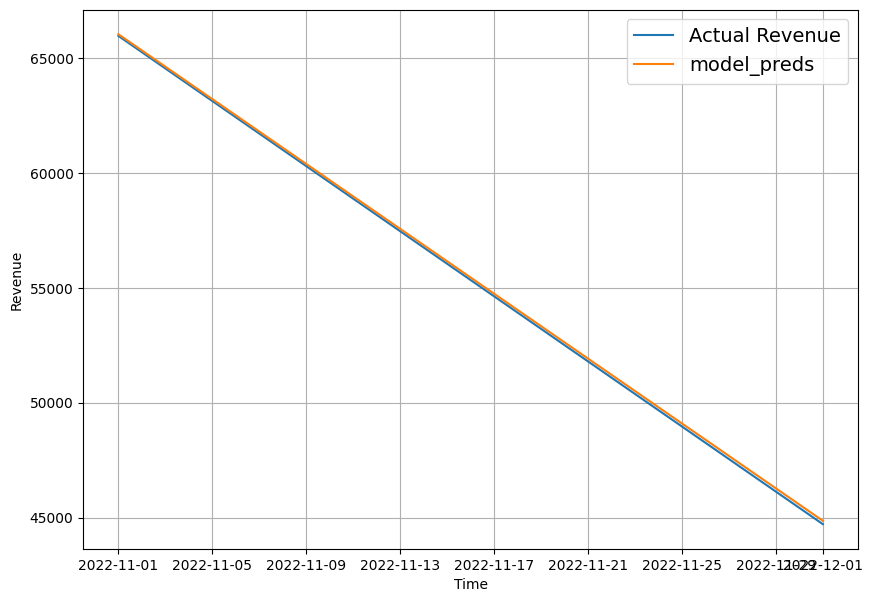

In [27]:
preds = best_model.predict(test_windows)
plot_preds(test_labels, preds)